# Introducción:
- Visualización y analisis de datos de Airbnb en Amsterdam a Diciembre 2023
- Comparación  2016 - 2023
<center><img src="/Users/aguedagambon/Bootcamp/Github/EDA_Airbnb_Amsterdam/Imagenes/amsterdam_boathouse.jpeg" width="50%"></center>





In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import json

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import squarify
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)



# Lectura de datos

In [19]:
#datos de 2023

listings = pd.read_csv("/Users/aguedagambon/Bootcamp/Github/EDA_Airbnb_Amsterdam/input2023/listings.csv")
listings_details = pd.read_csv('/Users/aguedagambon/Bootcamp/Github/EDA_Airbnb_Amsterdam/input2023/listings.csv.gz')

calendar = pd.read_csv("/Users/aguedagambon/Bootcamp/Github/EDA_Airbnb_Amsterdam/input2023/calendar.csv.gz", parse_dates=['date'], index_col=['listing_id'])

reviews = pd.read_csv("/Users/aguedagambon/Bootcamp/Github/EDA_Airbnb_Amsterdam/input2023/reviews.csv", parse_dates=['date'])
reviews_details = pd.read_csv("/Users/aguedagambon/Bootcamp/Github/EDA_Airbnb_Amsterdam/input2023/reviews.csv.gz", parse_dates=['date'])

barrio = gpd.read_file('/Users/aguedagambon/Bootcamp/Github/EDA_Airbnb_Amsterdam/input2023/neighbourhoods.csv')


# Limpieza de datos. 

## Listings

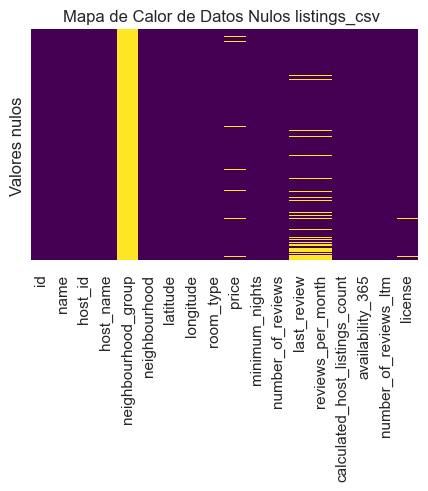

In [20]:
plt.figure(figsize=(5, 3))  
sns.heatmap(listings.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Mapa de Calor de Datos Nulos listings_csv ')
plt.ylabel('Valores nulos')

plt.show()  

In [21]:
#Elimino columnas vacias y que no me interesen
listings = listings.drop(columns=['neighbourhood_group', 'last_review', 'reviews_per_month', 'license'])

In [22]:
# Supongamos que el DataFrame se llama df y la columna a modificar se llama 'columna'
listings['host_name'] = listings['host_name'].fillna('desconocido')

In [23]:
# Solo el 3.39% de los datos price faltan, así que los cambio por la media

media_price = listings['price'].mean()
listings['price'] = listings['price'].fillna(media_price)

In [7]:
listings['price'] = listings['price'].astype(int)

In [8]:
#Descargo el csv limpio para usar en PowerBI
listings.to_csv('listings_limpio.csv', index=False)
print(os.getcwd())


/Users/aguedagambon/Bootcamp/Github/EDA_Airbnb_Amsterdam


# Listings details

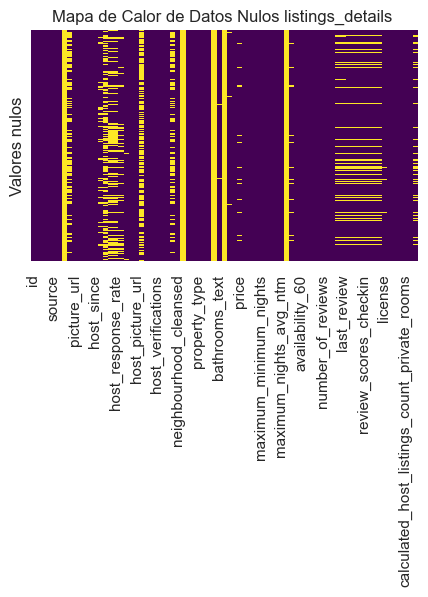

In [9]:
plt.figure(figsize=(5, 3))  
sns.heatmap(listings_details.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Mapa de Calor de Datos Nulos listings_details ')
plt.ylabel('Valores nulos')

plt.show()  

In [10]:
# Columnas seleccionadas de cada DataFrame
listings_columns = ['id', 'name', 'host_id', 'neighbourhood', 'room_type', 'number_of_reviews', 'price']
details_columns =["id", "property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate"]


listings_selected = listings[listings_columns]
listings_details_selected = listings_details[details_columns]


In [11]:
merged_listings = pd.merge(listings_selected, listings_details_selected, on='id', how='left')

In [12]:
merged_listings.isnull().sum()

id                                0
name                              0
host_id                           0
neighbourhood                     0
room_type                         0
number_of_reviews                 0
price                             0
property_type                     0
accommodates                      0
first_review                    922
review_scores_value             915
review_scores_cleanliness       915
review_scores_location          915
review_scores_accuracy          914
review_scores_communication     914
review_scores_checkin           914
review_scores_rating            914
maximum_nights                    0
listing_url                       0
host_is_superhost                52
host_about                     4032
host_response_time             3060
host_response_rate             3060
dtype: int64

In [13]:
#Traducción columna room_type
traduccion = {
    'Private room': 'Habitación privada',
    'Hotel room': 'Habitación de Hotel', 
    'Shared room': 'Habitación Compartida',
    'Entire home/apt': 'Casa/Apartamento entero',
    'Private room': 'Habitación Privada'
}

# Replazo valores
merged_listings['room_type'] = merged_listings['room_type'].replace(traduccion)

# Análisis exploratorio de datos

La media de precio es 350€
Calculo del precio medio por barrio

In [14]:

listings['price'] = listings['price']

entire_home_prices = listings[listings['room_type'] == 'Entire home/apt']['price']
private_room_prices = listings[listings['room_type'] == 'Private room']['price']


avg_entire_home_price = entire_home_prices.mean()
avg_private_room_price = private_room_prices.mean()


price_ratio = avg_entire_home_price / avg_private_room_price

print(f"Average Entire home/apt price: {avg_entire_home_price}")
print(f"Average Private room price: {avg_private_room_price}")
print(f"Price ratio (Entire home/apt to Private room): {price_ratio}")

Average Entire home/apt price: 273.2310820624546
Average Private room price: 170.18326693227093
Price ratio (Entire home/apt to Private room): 1.6055108530217272


In [ ]:
listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm'],
      dtype='object')

In [ ]:
# Asegurarse de que las columnas están en el formato correcto
# listings['number_of_reviews'] = pd.to_numeric(listings['number_of_reviews'], errors='coerce')
# listings['availability_365'] = pd.to_numeric(listings['availability_365'], errors='coerce')

# Filtrar por tipo de habitación
entire_home = listings[listings['room_type'] == 'Entire home/apt']
private_room = listings[listings['room_type'] == 'Private room']

# Calcular medias para precios, número de reseñas y disponibilidad
avg_entire_home_price = entire_home['price'].mean()
avg_private_room_price = private_room['price'].mean()

avg_entire_home_reviews = entire_home['number_of_reviews'].mean()
avg_private_room_reviews = private_room['number_of_reviews'].mean()

avg_entire_home_availability = entire_home['availability_365'].mean()
avg_private_room_availability = private_room['availability_365'].mean()

# Imprimir resultados
print(f"Average Entire home/apt price: {avg_entire_home_price}")
print(f"Average Private room price: {avg_private_room_price}")
print(f"Average Entire home/apt number of reviews: {avg_entire_home_reviews}")
print(f"Average Private room number of reviews: {avg_private_room_reviews}")
print(f"Average Entire home/apt availability: {avg_entire_home_availability}")
print(f"Average Private room availability: {avg_private_room_availability}")

Average Entire home/apt price: 273.2310820624546
Average Private room price: 170.18326693227093
Average Entire home/apt number of reviews: 21.12868554829339
Average Private room number of reviews: 133.1394422310757
Average Entire home/apt availability: 66.91125635439361
Average Private room availability: 129.98747865680136


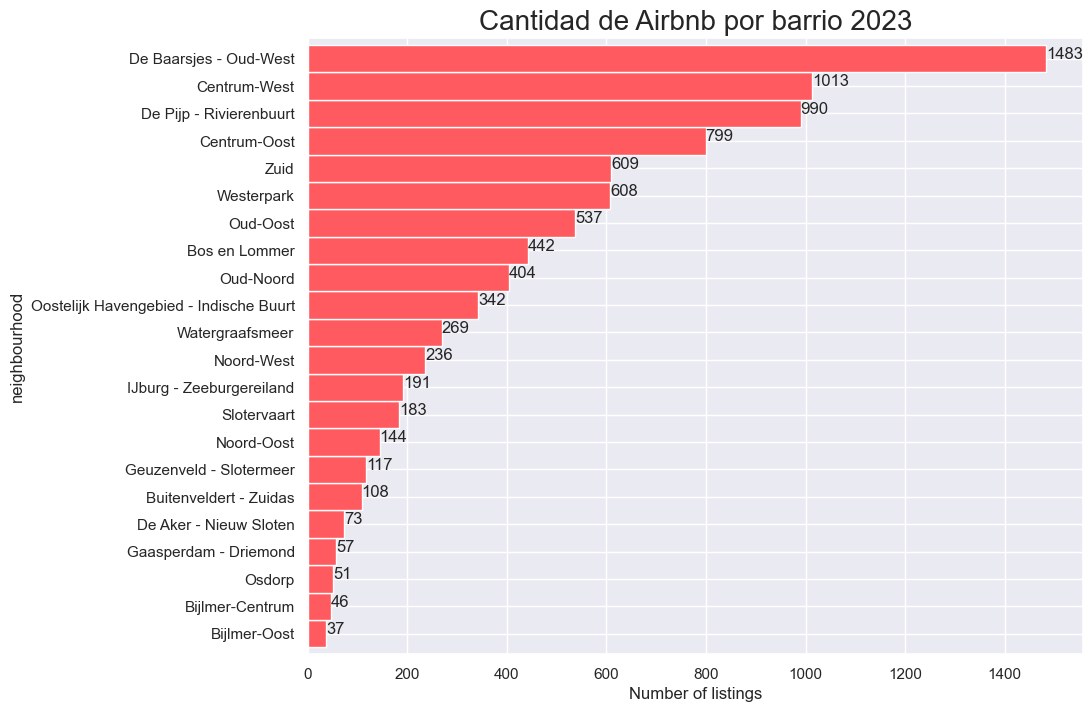

In [ ]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='#FF5A5F', width=1)

for index, value in enumerate(feq):
    plt.text(value, index, str(value))
    
plt.title("Cantidad de Airbnb por barrio 2023", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

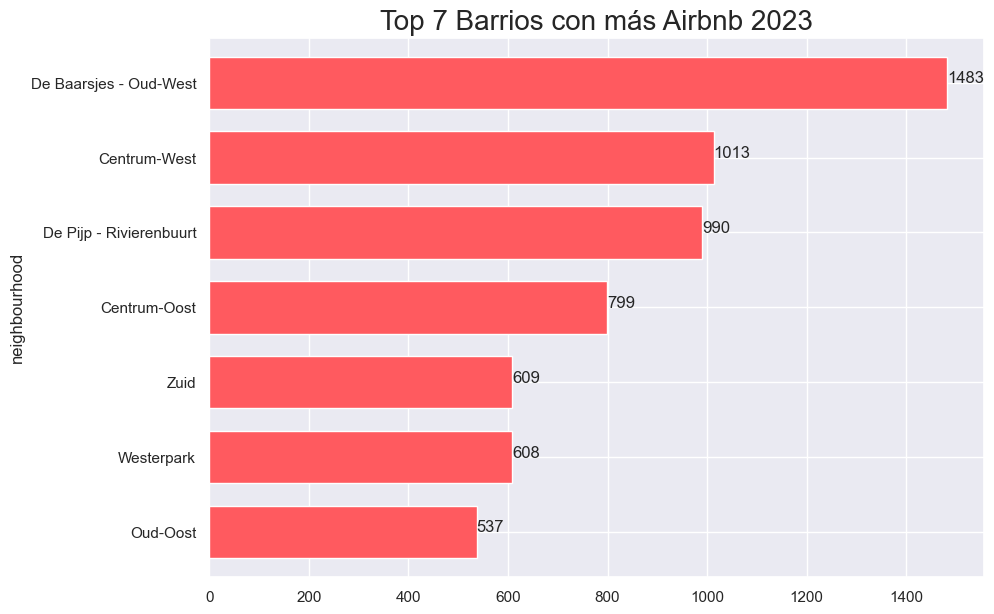

In [ ]:

top_7_frequencies = listings['neighbourhood'].value_counts().sort_values(ascending=True).tail(7)

top_7_frequencies.plot.barh(figsize=(10, 7), color='#FF5A5F', width=0.7)

for index, value in enumerate(top_7_frequencies):
    plt.text(value, index, str(value))

plt.title("Top 7 Barrios con más Airbnb 2023", fontsize=20)

# Mostrar el gráfico
plt.show()

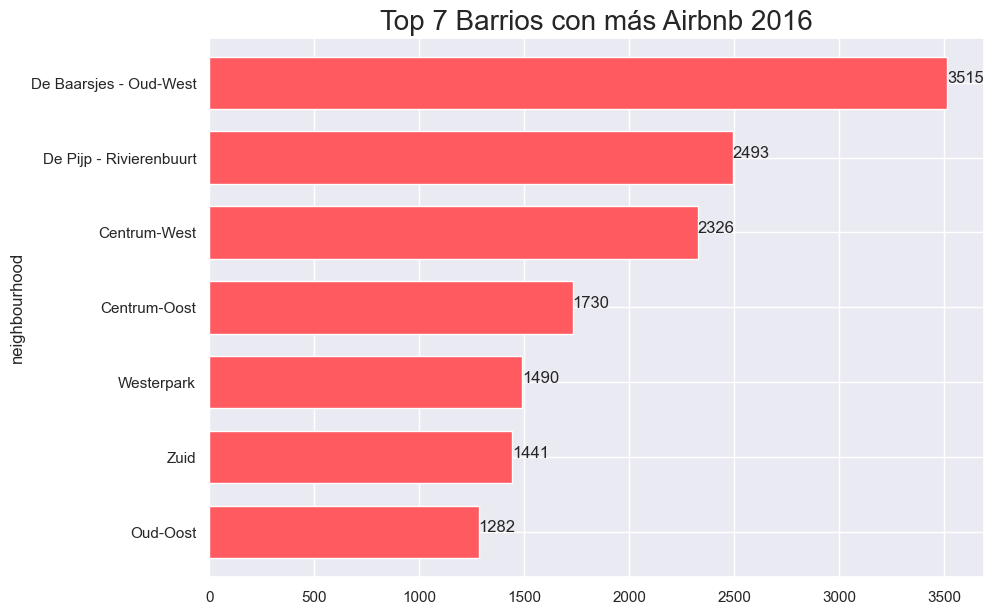

In [ ]:

top_7_frequencies = listings2016['neighbourhood'].value_counts().sort_values(ascending=True).tail(7)
top_7_frequencies.plot.barh(figsize=(10, 7), color='#FF5A5F', width=0.7)

for index, value in enumerate(top_7_frequencies):
    plt.text(value, index, str(value))

plt.title("Top 7 Barrios con más Airbnb 2016", fontsize=20)
plt.show()

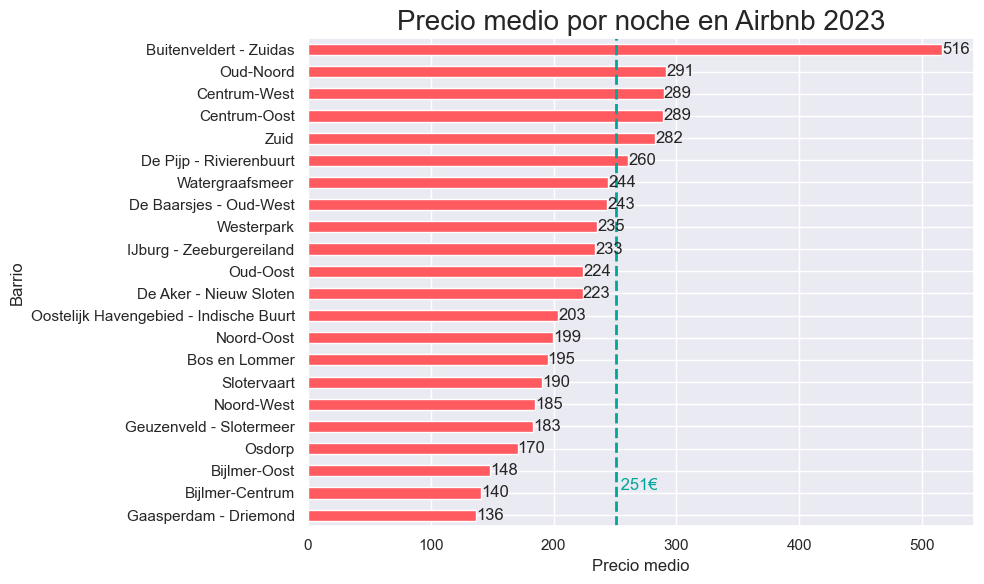

In [ ]:

media_precio_barrio = listings.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)

media_precio_barrio.plot(kind='barh', color='#FF5A5F', figsize=(10, 6, ))

plt.title('Precio medio por noche en Airbnb 2023', fontsize=20)
plt.ylabel('Barrio')
plt.xlabel('Precio medio')
plt.axvline(x=precio_medio_total, color='#00A699', linestyle='--', linewidth=2)
plt.axhline(y=precio_medio_total, color='r', linestyle='-', linewidth=0.5)  
plt.text(precio_medio_total, len(media_precio_barrio)/2 - ajuste_vertical, f" {int(precio_medio_total)}€", color='#00A699', va='bottom')
for index, value in enumerate(media_precio_barrio):
    plt.text(value, index, f"{int(value)}", va='center')

plt.tight_layout()  

plt.show()

In [ ]:
listings['price'].mean()

251.15528092459093

In [ ]:
listings.groupby('neighbourhood')

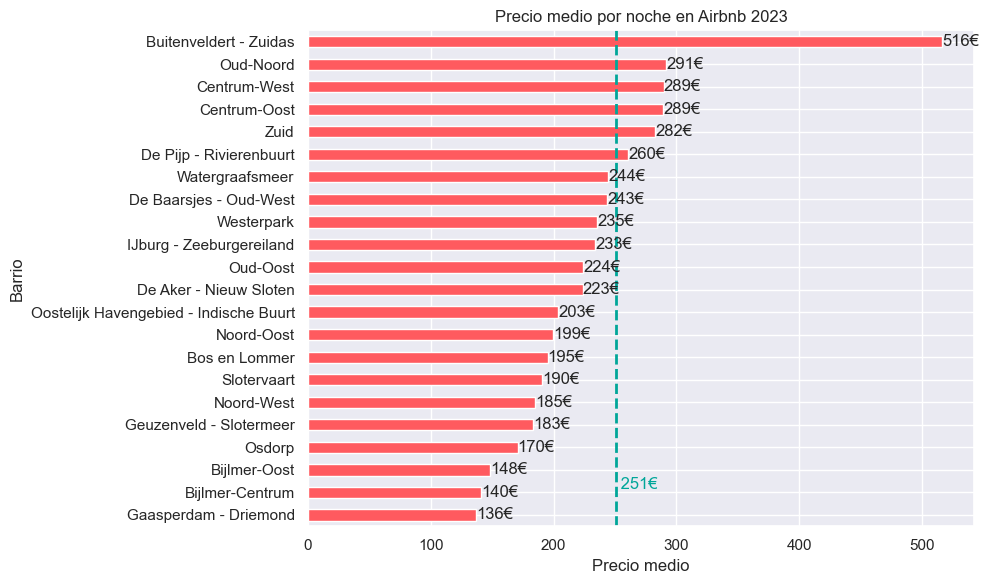

In [ ]:
media_precio_barrio = listings.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
media_precio_barrio.plot(kind='barh', color='#FF5A5F', figsize=(10, 6))

plt.title('Precio medio por noche en Airbnb 2023')
plt.ylabel('Barrio')
plt.xlabel('Precio medio')

# Precio medio total
precio_medio_total = listings['price'].mean()
plt.axvline(x=precio_medio_total, color='#00A699', linestyle='--', linewidth=2)
plt.axhline(y=precio_medio_total, color='r', linestyle='-', linewidth=0.5)  
ajuste_vertical = 10  
plt.text(precio_medio_total, len(media_precio_barrio)/2 - ajuste_vertical, f" {int(precio_medio_total)}€", color='#00A699', va='bottom')

for index, value in enumerate(media_precio_barrio):
    plt.text(value, index, f"{int(value)}€", va='center')

plt.tight_layout()
plt.show()

# Mapas

#### En este mapa puedes ver donde se encuentran los barrios, al igual que la localización de las atracciones turísticas más poupulares

In [ ]:

with open('/Users/aguedagambon/Bootcamp/Github/EDA_Airbnb_Amsterdam/input2016/neighbourhoods.geojson', 'r') as f:
    amsterdam_districts = json.load(f)

mapa_barrios = folium.Map(location=[52.3676, 4.9041], zoom_start=13)
airbnb_color = '#FF5A5F'  
def style_function(feature):
    return {
        'fillColor': airbnb_color,
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.2
    }
def highlight_function(feature):
    return {
        'fillColor': airbnb_color,
        'color': 'black',
        'weight': 3,
        'fillOpacity': 0.5
    }
folium.GeoJson(
    amsterdam_districts,
    name='Amsterdam Neighbourhoods',
    style_function=style_function,
    highlight_function=highlight_function,
    tooltip=folium.GeoJsonTooltip(fields=['neighbourhood'], aliases=['Barrio:'], localize=True)
).add_to(mapa_barrios)

atracciones = [
    {'nombre': 'Rijksmuseum', 'coordenadas': [52.359998, 4.885219]},
    {'nombre': 'Casa de Ana Frank', 'coordenadas': [52.375218, 4.884248]},
    {'nombre': 'Museo Van Gogh', 'coordenadas': [52.358416, 4.881076]},
    {'nombre': 'Vondelpark', 'coordenadas': [52.358179, 4.868648]},
    {'nombre': 'Plaza Dam', 'coordenadas': [52.373143, 4.892481]},
    {'nombre': 'Heineken Experience', 'coordenadas': [52.357846, 4.891924]},
    {'nombre': 'Mercado de Flores', 'coordenadas': [52.366797, 4.889273]},
    {'nombre': 'Jordaan', 'coordenadas': [52.377956, 4.879377]},
    {'nombre': 'Museo de la Ciencia NEMO', 'coordenadas': [52.373859, 4.912560]},
    {'nombre': 'Palacio Real', 'coordenadas': [52.373160, 4.891902]}
]


for atraccion in atracciones:
    folium.Marker(
        location=atraccion['coordenadas'],
        popup=f"{atraccion['nombre']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(mapa_barrios)

mapa_barrios



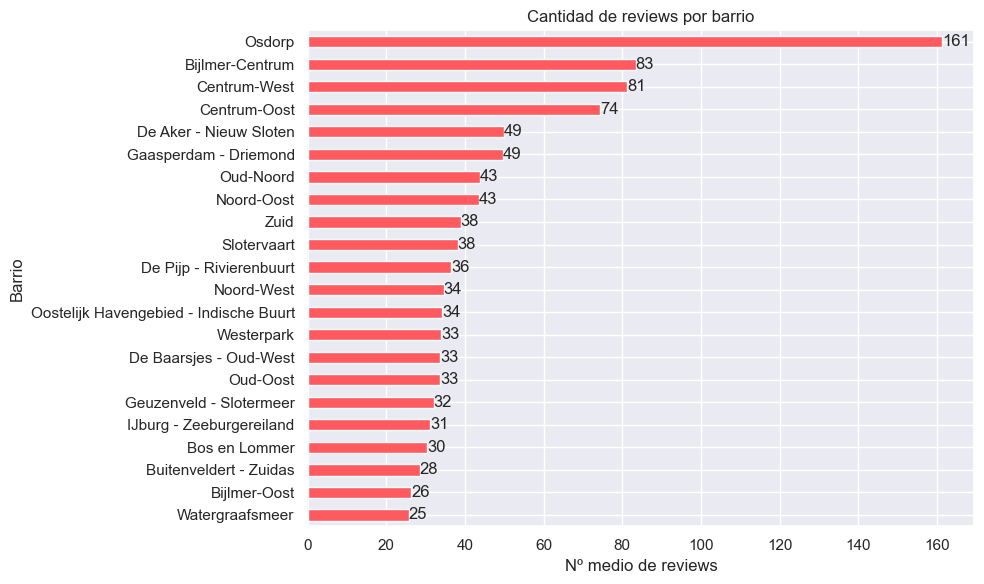

In [ ]:

media_precio_barrio = listings.groupby('neighbourhood')['number_of_reviews'].mean().sort_values(ascending=True)

media_precio_barrio.plot(kind='barh',color='#FF5A5F', figsize=(10, 6))

plt.title('Cantidad de reviews por barrio')
plt.ylabel('Barrio')
plt.xlabel('Nº medio de reviews')

for index, value in enumerate(media_precio_barrio):
    plt.text(value, index, f"{int(value)}", va='center')

plt.tight_layout()  

plt.show()

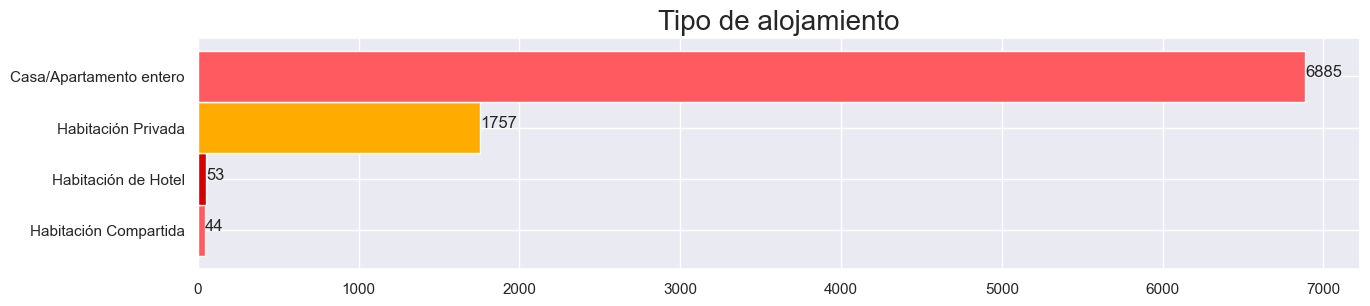

In [ ]:
plt.title('Tipo de alojamiento',fontsize=20)
freq = merged_listings['room_type'].value_counts().sort_values(ascending=True)

airbnb_colors = ["#FF5A5F", "#D50000", "#FFAB00"]  
for index, value in enumerate(freq):
    plt.text(value, index, str(value))
freq.plot.barh(figsize=(15, 3), width=1, color=airbnb_colors)
plt.xlabel('Nº medio de reviews')
plt.show()

In [ ]:
merged_listings['room_type'].value_counts() 

room_type
Entire home/apt    6885
Private room       1757
Hotel room           53
Shared room          44
Name: count, dtype: int64

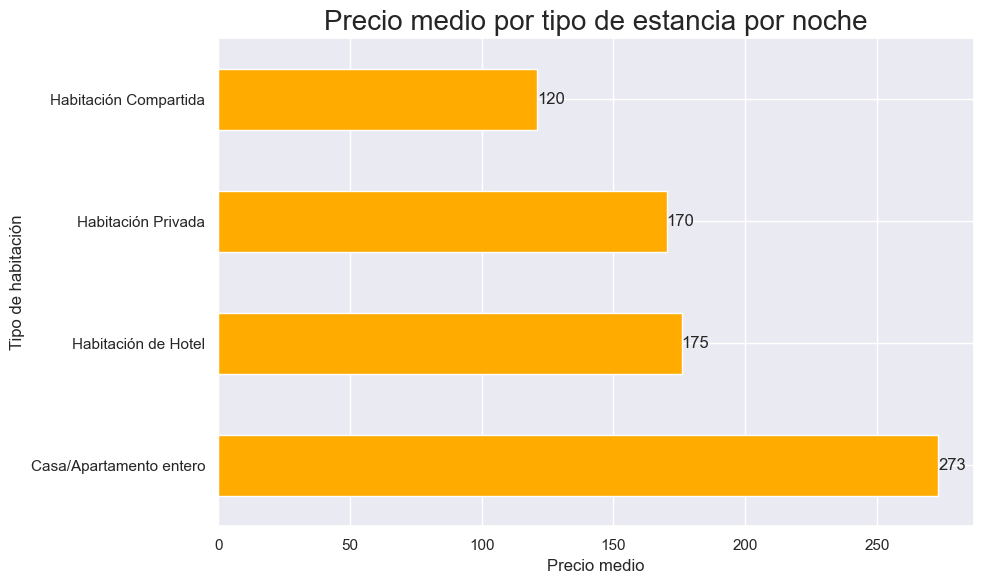

In [ ]:
media_precio_room = merged_listings.groupby('room_type')['price'].mean().sort_values(ascending=False)
media_precio_room.plot(kind='barh',color='#FFAB00', figsize=(10, 6))

plt.title('Precio medio por tipo de estancia por noche',fontsize=20)
plt.ylabel('Tipo de habitación')  
plt.xlabel('Precio medio')

for index, value in enumerate(media_precio_room):
    plt.text(value, index, f"{int(value)}", va='center')

plt.tight_layout()  
plt.show()



In [ ]:
listings.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm'],
      dtype='object')

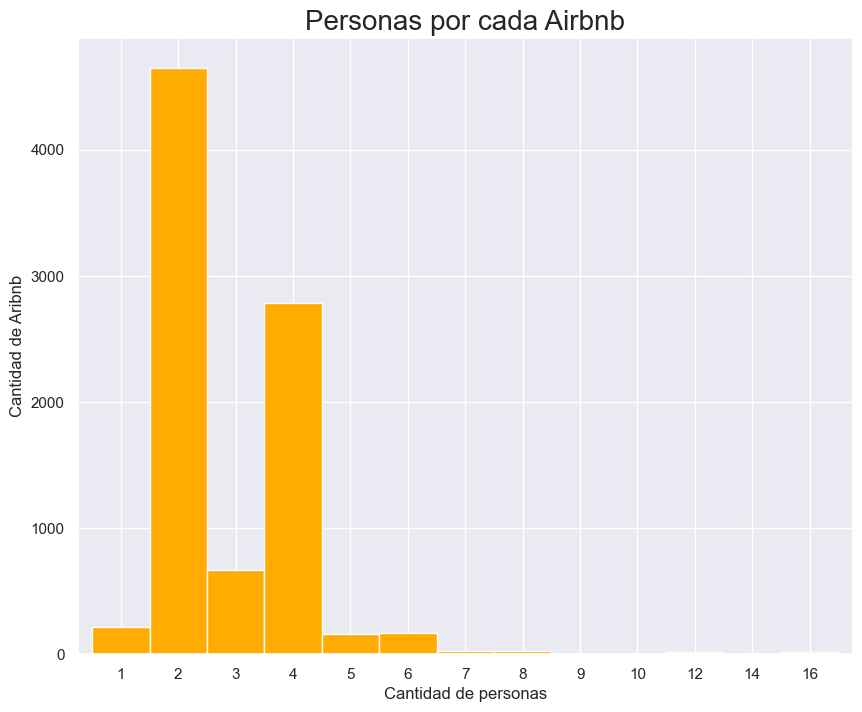

In [25]:
feq=merged_listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='#FFAB00', width=1, rot=0)
plt.title("Personas por cada Airbnb", fontsize=20)
plt.ylabel('Cantidad de Aribnb')
plt.xlabel('Cantidad de personas', fontsize=12, )
plt.show()

TypeError: text() missing 2 required positional arguments: 'y' and 's'

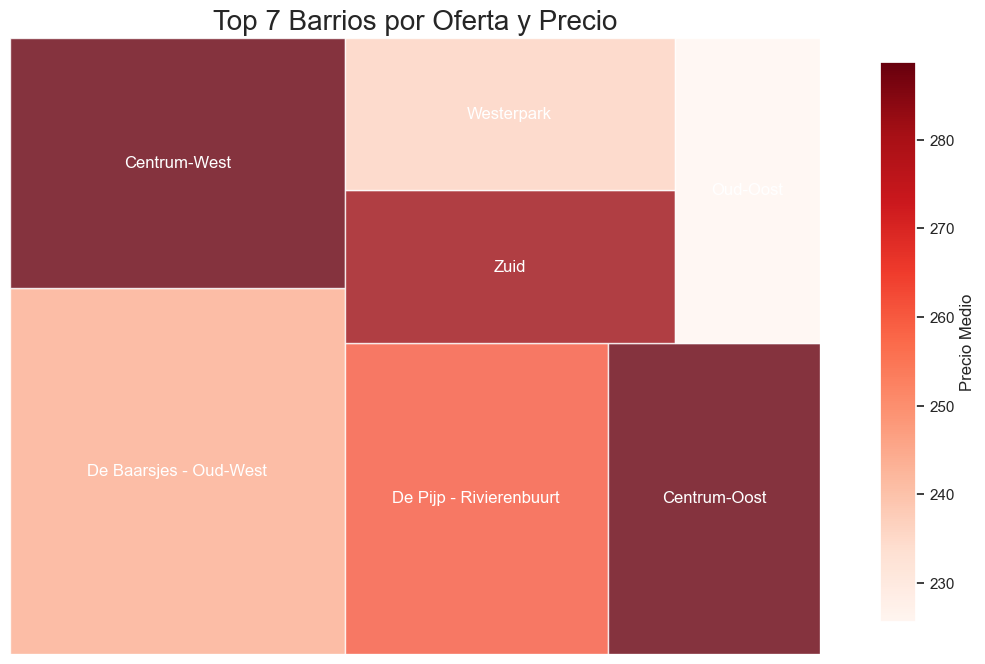

In [29]:

precio_medio = merged_listings['price'].mean()
merged_listings['price'] = merged_listings['price'].fillna(precio_medio)
precio_medio_por_barrio = merged_listings.groupby('neighbourhood')['price'].mean()
ofertas_por_barrio = merged_listings['neighbourhood'].value_counts()

#top 7 barrios con más ofertas
top_barrios = ofertas_por_barrio.head(7).index
data_top7 = pd.DataFrame({
    'barrio': top_barrios,
    'oferta': ofertas_por_barrio.loc[top_barrios],
    'precio': precio_medio_por_barrio.loc[top_barrios]
})

norm = plt.Normalize(data_top7['precio'].min(), data_top7['precio'].max())
colors = plt.cm.Reds(norm(data_top7['precio']))  


fig, ax = plt.subplots(figsize=(12, 8))


squarify.plot(sizes=data_top7['oferta'], label=data_top7['barrio'], color=colors, alpha=0.8,
            text_kwargs={'fontsize':12, 'color':'white'}, ax=ax)


plt.title('Top 7 Barrios por Oferta y Precio', fontsize=20)
plt.axis('off')


fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.15, 0.03, 0.7])  # Posición [izquierda, abajo, ancho, alto]


sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Precio Medio')
plt.text('El color muestra el precio medio por barrio, el tamaño muestra la cantidad de ofertas')
plt.show()


In [ ]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,private_rooms
2333,67005410,Feliciano,15
2013,44168250,Ruben,13
866,10076897,Geraldine,13
256,3040748,Henk,10
3253,212600641,Valentina,8


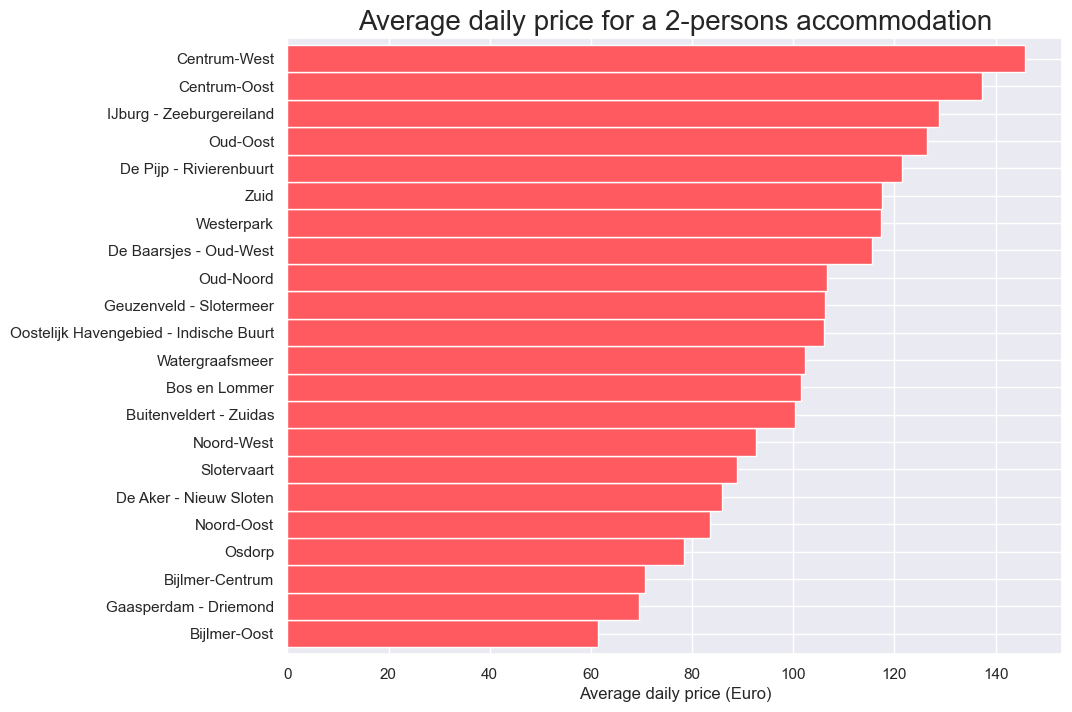

In [ ]:
#Precio medio pora estancia de dos personas

feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='#FF5A5F', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

Para analizar las reviews post stay, creo un nuevo dataframe con solo las columnas objetivo. Claramente se ve que solo se han guardado las reviews de los huespedes que respondieron a todas las preguntas. Por ello directamente, para los objetivos de este dataframe, eliminaré las filas con valores nulos.

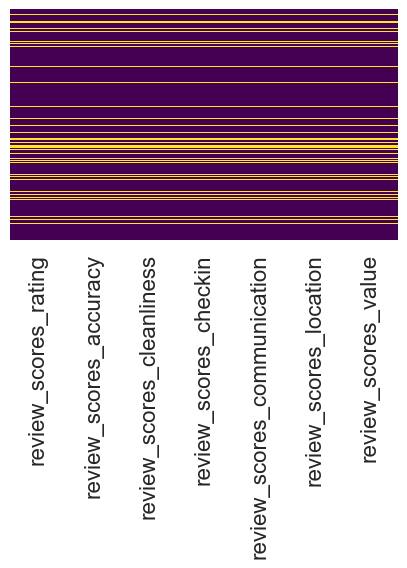

In [ ]:
reviews_post_stay = listings_details[['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]
plt.figure(figsize=(5, 3))
sns.heatmap(reviews_post_stay.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.show()

In [ ]:
reviews_post_stay.isnull().sum()    

review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
dtype: int64

In [ ]:
reviews_post_stay.groupby()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,4.60,4.60,4.40,4.40,4.60,4.60,4.40
1,5.00,4.67,4.83,4.83,5.00,4.67,4.83
2,4.71,4.80,4.65,4.87,4.96,4.57,4.57
3,4.86,4.95,4.93,4.95,4.98,5.00,4.84
4,5.00,5.00,5.00,5.00,5.00,5.00,4.40


# Calendar

In [ ]:
calendar.head()

,date,available,price,minimum_nights,maximum_nights
listing_id,,,,,
2818,2023-12-12,f,$59.00,3,1125
2818,2023-12-13,f,$59.00,3,1125
2818,2023-12-14,f,$59.00,3,1125
2818,2023-12-15,f,$59.00,3,1125
2818,2023-12-16,f,$59.00,3,1125


In [ ]:
calendar.drop(columns=['adjusted_price'], inplace=True)

In [ ]:
calendar.value_counts()

date        available  price    minimum_nights  maximum_nights
2023-12-30  f          $150.00  2               1125              66
2023-12-31  f          $150.00  2               1125              63
2023-12-28  f          $150.00  2               1125              62
2023-12-29  f          $150.00  2               1125              62
2023-12-16  f          $150.00  2               1125              61
                                                                  ..
2024-04-26  f          $240.00  3               20                 1
                                                16                 1
                                                14                 1
                                                9                  1
2024-12-11  t          $180.00  3               1125               1
Length: 1873434, dtype: int64

In [ ]:
calendar['date'].min()

Timestamp('2023-12-12 00:00:00')

In [ ]:
calendar['date'].max()

Timestamp('2024-12-11 00:00:00')

In [ ]:
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)
calendar.head()

,date,available,price,minimum_nights,maximum_nights
listing_id,,,,,
2818,2023-12-12,f,59.0,3,1125
2818,2023-12-13,f,59.0,3,1125
2818,2023-12-14,f,59.0,3,1125
2818,2023-12-15,f,59.0,3,1125
2818,2023-12-16,f,59.0,3,1125


In [ ]:
#Funcion para analizar los precios de un alojamiento en particular
airbnb = calendar.loc[calendar.index == 2765]

# Reviews

In [ ]:
reviews.head()

,listing_id,date
0,2818,2009-03-30
1,2818,2009-04-24
2,2818,2009-05-03
3,2818,2009-05-18
4,2818,2009-05-25


#### El número de reviews, claramente un fuerte factor social que ayuda al mayor número de reservas, ha mantenido una tendencia positiva desde el lanzamiento de Airbnb, solo en Amsterdam, de media, el número de reviews ha aumentado un 129% de media, incluyendo los graves efectos de la pandemia en el número de reservas.

In [ ]:
merged_listings.columns

Index(['id', 'name', 'host_id', 'neighbourhood', 'room_type',
       'number_of_reviews', 'price', 'property_type', 'accommodates',
       'first_review', 'review_scores_value', 'review_scores_cleanliness',
       'review_scores_location', 'review_scores_accuracy',
       'review_scores_communication', 'review_scores_checkin',
       'review_scores_rating', 'maximum_nights', 'listing_url',
       'host_is_superhost', 'host_about', 'host_response_time',
       'host_response_rate'],
      dtype='object')

In [ ]:
merged_listings = merged_listings[merged_listings['date'] <= '2023-12-21']
monthly_reviews = reviews_filtered.resample('M', on='date').size()

airbnb_color = '#FF5A5F'
grid_color = '#FF5A5F'

plt.figure(figsize=(14, 7))
plt.plot(monthly_reviews.index, monthly_reviews.values, color=airbnb_color, linestyle='-')
plt.title('Number of Reviews per Month')
plt.ylabel('Number of Reviews')
plt.xlim([monthly_reviews.index.min(), pd.Timestamp('2023-12-1')])
plt.grid(True, color=grid_color, alpha=0.1)
plt.show()

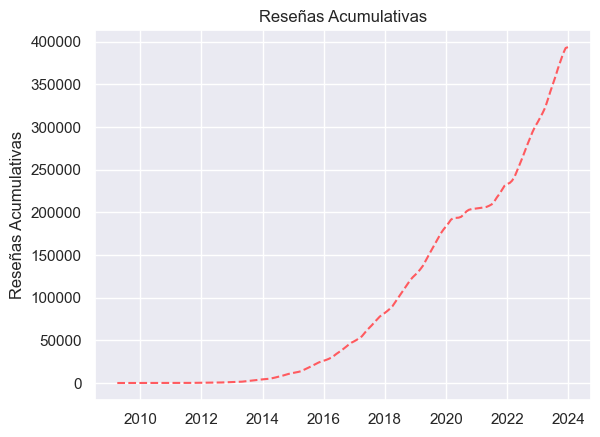

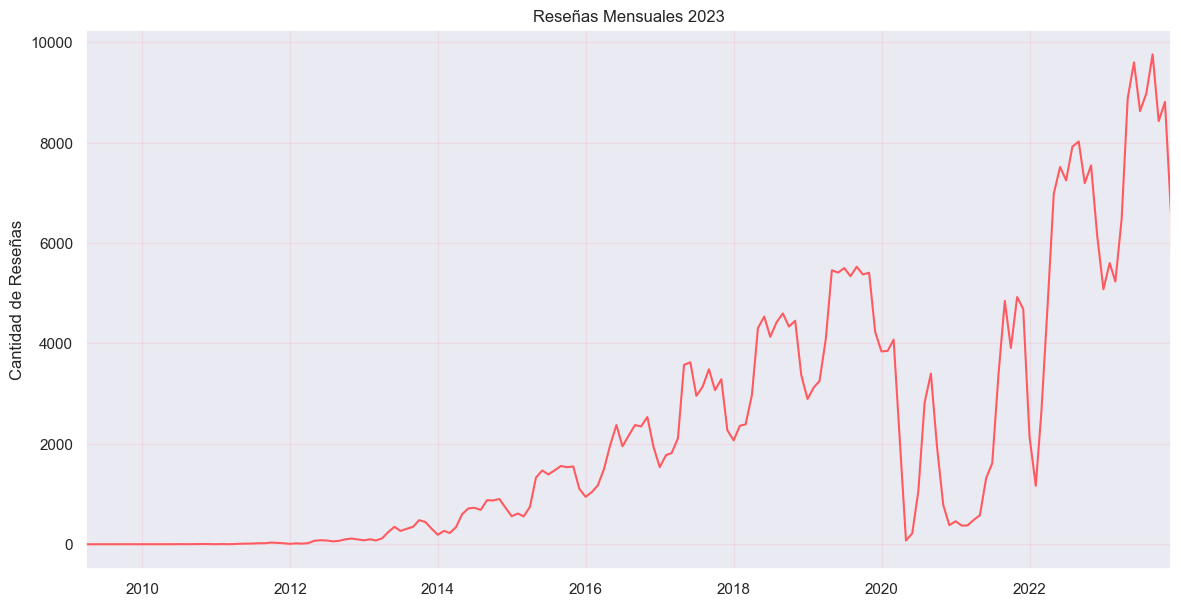

In [48]:
reviews_filtered = reviews[reviews['date'] <= '2023-12-21']
monthly_reviews = reviews_filtered.resample('M', on='date').size()

airbnb_color = '#FF5A5F'
grid_color = '#FF5A5F'

cumulative_reviews = monthly_reviews.cumsum()
plt.plot(cumulative_reviews.index, cumulative_reviews.values, color='#FF5A5F', linestyle='--', label='Total Acumulativo de Reseñas')
plt.ylabel('Reseñas Acumulativas')
plt.title('Reseñas Acumulativas')

plt.figure(figsize=(14, 7))
plt.plot(monthly_reviews.index, monthly_reviews.values, color=airbnb_color, linestyle='-')
plt.title('Reseñas Mensuales 2023')
plt.ylabel('Cantidad de Reseñas')
plt.xlim([monthly_reviews.index.min(), pd.Timestamp('2023-12-1')])
plt.grid(True, color=grid_color, alpha=0.1)
plt.show()

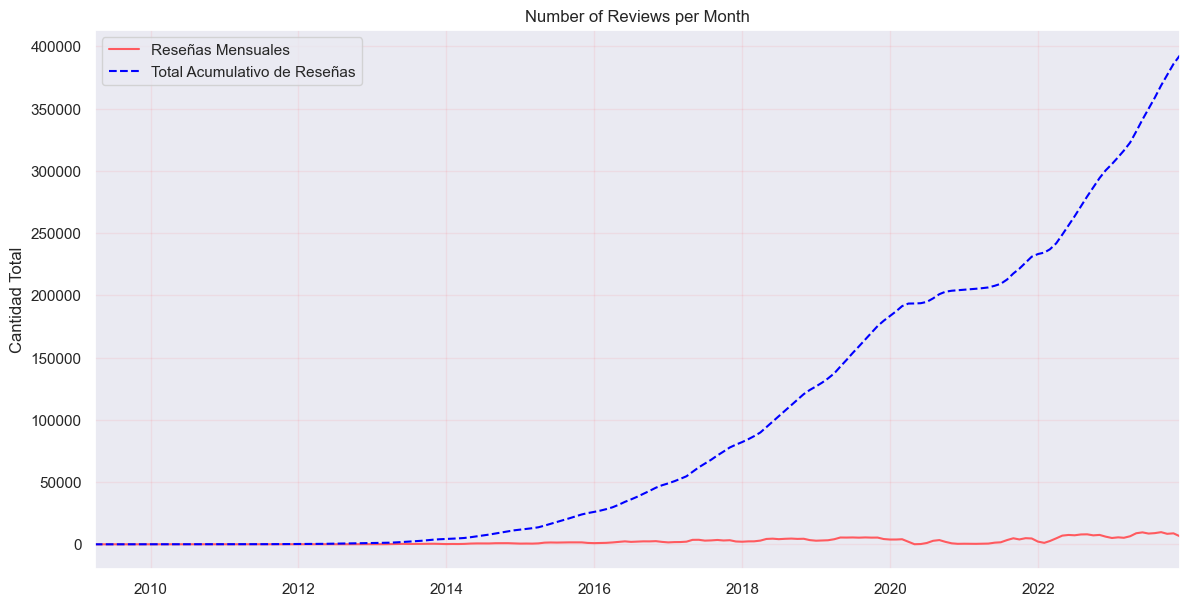

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supongamos que reviews ya está definido y contiene las columnas necesarias
reviews_filtered = reviews[reviews['date'] <= '2023-12-21']
monthly_reviews = reviews_filtered.resample('M', on='date').size()

airbnb_color = '#FF5A5F'
grid_color = '#FF5A5F'

# Calcular el total acumulativo de reseñas
cumulative_reviews = monthly_reviews.cumsum()

plt.figure(figsize=(14, 7))

# Plot de reseñas mensuales
plt.plot(monthly_reviews.index, monthly_reviews.values, color=airbnb_color, linestyle='-', label='Reseñas Mensuales')

# Plot de reseñas acumulativas
plt.plot(cumulative_reviews.index, cumulative_reviews.values, color='blue', linestyle='--', label='Total Acumulativo de Reseñas')

plt.title('Number of Reviews per Month')
plt.ylabel('Cantidad Total')
plt.xlim([monthly_reviews.index.min(), pd.Timestamp('2023-12-1')])
plt.grid(True, color=grid_color, alpha=0.1)
plt.legend()
plt.show()


El gráfico representa el número total de reseñas recibidas por mes hasta el 21 de diciembre de 2023. En el eje x se muestran los meses, y en el eje y se muestra la cantidad de reseñas recibidas en cada mes.

In [ ]:
annual_reviews = reviews_filtered.resample('A', on='date').size()
crecimiento_anual = annual_reviews.diff().dropna().astype(int) 

annual_growth_df = pd.DataFrame({
    'Total Reviews': annual_reviews,
    'Annual Growth': crecimiento_anual,
    'Growth %': crecimiento_anual_pct
})

# Elimino el primer dato ya q es NaN
annual_growth_df = annual_growth_df.iloc[1:]


annual_growth_df


,Total Reviews,Annual Growth,Growth %
date,,,
2010-12-31,33,21.0,175.0
2011-12-31,185,152.0,461.0
2012-12-31,800,615.0,332.0
2013-12-31,3236,2436.0,304.0
2014-12-31,7500,4264.0,132.0
2015-12-31,14271,6771.0,90.0
2016-12-31,22909,8638.0,61.0
2017-12-31,33175,10266.0,45.0
2018-12-31,44751,11576.0,35.0


In [ ]:
annual_growth_df['Growth %'].mean()

129.14285714285714

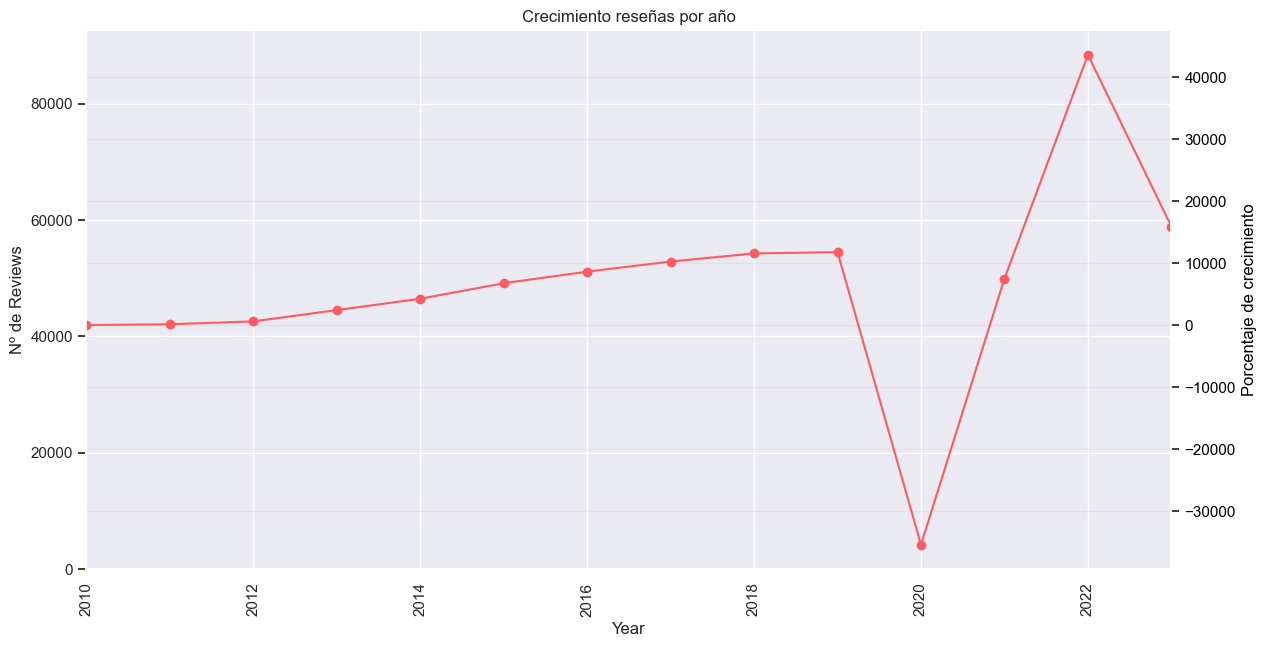

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax1 = plt.subplots(figsize=(14, 7))

annual_reviews.plot(kind='bar', ax=ax1)
ax1.set_title('Crecimiento reseñas por año')
ax1.set_ylabel('Nº de Reviews')
ax1.tick_params(axis='y')
ax1.set_xlabel('Year')

ax2 = ax1.twinx()
crecimiento_anual.plot(kind='line', marker='o', color=airbnb_color, ax=ax2)
ax2.set_ylabel('Porcentaje de crecimiento', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Mostrar la gráfica
plt.grid(True, color=grid_color, alpha=0.1)  # Utilizar el color de Airbnb también para la cuadrícula
plt.show()


In [ ]:
reviews_details['comments'] = reviews_details['comments'].fillna('')

In [39]:
reviews_details.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         21
dtype: int64

In [ ]:
reviews_details.to_csv('reviews_details.csv', index=False)

In [40]:
reviews_details.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

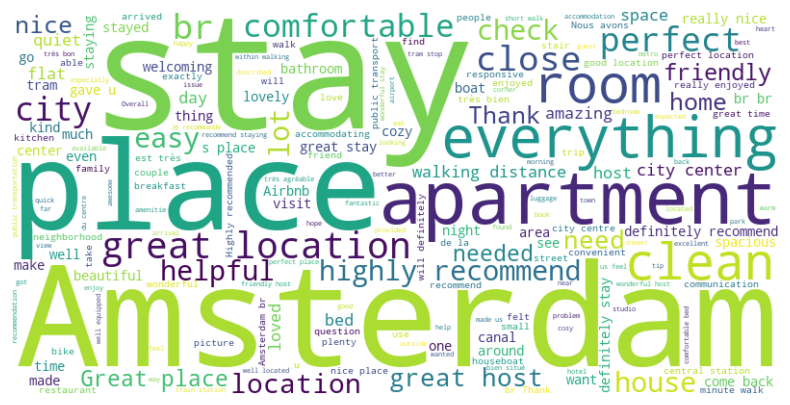

In [57]:
text = " ".join(comment for comment in reviews_details['comments'].dropna())
worlcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
